<a href="https://colab.research.google.com/github/HugoKD/byoRNA/blob/main/ByoRna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import random
import math
import numpy as np
from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import random as rd

**Réferences :** <br>
Pour la partie DSP  :

*  Model-based design and control of a small-scale integrated (Morten Ryberg Wahlgreen et al. / IFAC PapersOnLine 55-7 (2022)
continuous end-to-end mAb platform)
*  Modeling and Simulation of Upstream and
Downstream Processes for Monoclonal
Antibody Production

Pour la partie USP :

*   *équations de monod*

## POO

On va faire un poo en python pour simuler le process de filtration. Chaque filtre possède une certaine affinité, des certaines caractéristiques. On veut arriver à un résultat optimal en un nombre d'étapes minimales -> programation sous contraintes. On veut un nombre de step min et un quantité d'ARN maximale (ou alors une pureté maximale). Pour l'instant on ne considère que la taille de la molécule d'interêt. <br><br>
De base on part d'une population de x% d'ARN,y% ADN, z% débris, w% de protéines, v% de virus et p% de petites molécules -> fixé. La masse totale de la mixture,elle n'est pas fixée. Cf UPS

#### USP

In [ ]:
# Modèle basée sur les  équations de Monod
class USP:
    def __init__(self, mu_max=0.4, K_s=0.9, Y_E=0.8, q_G=0.1, q_O=0.5, m=0.01, G0=20, X0=0.4, E0=0, O0=100):
        self.mu_max = mu_max  # taux de croissance spécifique maximal (h^-1)
        self.K_s = K_s  # constante de saturation de Monod pour le glucose (g/L)
        self.Y_E = Y_E  # yield de l'éthanol sur le glucose (g/g)
        self.q_G = q_G  # taux spécifique de consommation de glucose (g/g.h)
        self.q_O = q_O  # taux spécifique de consommation d'oxygène (%/g.h)
        self.m = m  # taux de maintenance (h^-1)
        # concentrations initiales
        self.G0 = G0  # c_i de glucose (g/L)
        self.X0 = X0  # c_i de biomasse (g/L)
        self.E0 = E0  # c_i d'éthanol (g/L)
        self.O0 = O0  # c_i d'oxygène (%)
        self.solution = None  # Variable pour stocker la solution

    def model(self, y, t):
        G, X, E, O = y
        mu = self.mu_max * (G / (self.K_s + G))
        dG_dt = -mu * X - self.q_G * X
        dX_dt = (mu - self.m) * X
        dE_dt = self.Y_E * (self.q_G - mu) * X
        dO_dt = -self.q_O * X
        return [dG_dt, dX_dt, dE_dt, dO_dt]

    def get_solution(self, t_end=30, n=100, plot=True):
        t = np.linspace(0, t_end, n)  # en heure
        y0 = [self.G0, self.X0, self.E0, self.O0]
        # Résoudre les équa diffs avec odeint
        self.solution = odeint(self.model, y0, t)
        G, X, E, O = self.solution.T
        if plot:
            # Créer le graphique
            plt.figure(figsize=(10, 6))
            plt.plot(t, G, label='Glucose')
            plt.plot(t, X, label='Biomasse')
            plt.plot(t, O, label='Oxygène (%)')
            plt.xlabel('Temps (h)')
            plt.ylabel('Concentration (g/L)')
            plt.title('Modèle de Sonnleitner et Käppeli et de Monod')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
          return G, X, E, O

    def get_masse_X(self, taille):  # taille en L
        if self.solution is None:
            self.get_solution(plot=False)
        G, X, E, O = self.solution.T
        return X[-1] * taille  # return g de biomasse

In [ ]:
usp = USP()

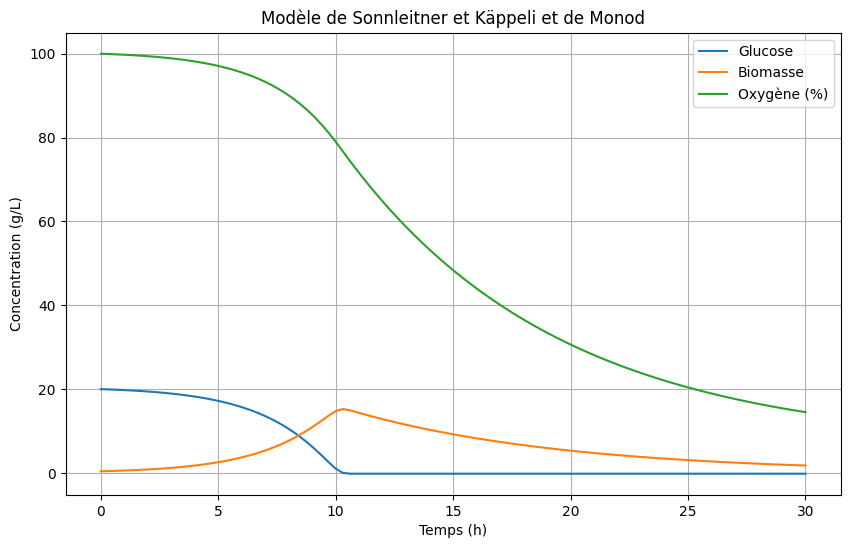

In [ ]:
usp.get_solution(plot=True)

#### Filtration par taille ou par charge

In [4]:
## Classe DSP pour simuler (fonction simulate) ou visualiser (fonction visu) un downstream process entier (plusieurs filtrations à la chaine possible)

class DSP:
    def __init__(self, feed, temperature,filtrations):
        """
        Initialisation de la classe DSP.
        :param feed: mélange de molécules initial.
        :param temperature: température de la solution.
        :param filtrations: ensemble des filtrations à effectuer, une liste de dictionnaires décrivant chaque étape de filtration.
        """
        self.feed = feed
        self.temperature = temperature
        self.filtrations = filtrations


    def simulate(self , transform, display = True):
        """
        Simule le processus de filtration.
        :param transform: booléen indiquant si l'on transforme le feed initial ou non
        :param display: booléen indiquant si les résultats doivent être affichés.
        :return: un dictionnaire avec les résultats de la filtration.
        """
        filtration_results = self.feed

        for filtration in self.filtrations:
            if filtration['type_filtration'] == 'size': #soit une filtration par taille
                filtration_ = Filtration(type_filtration = filtration['type_filtration'] ,feed = filtration_results,
                                         filter_size =filtration['filter_size'], filter_charge = None, pressure = filtration['pressure'],flow_rate = filtration['flow_rate'], temperature = self.temperature)
                filtration_.perform_filtration(type_ = filtration['type_'], transform = False)
            elif filtration['type_filtration'] == 'charge':#soit une filtration par charge
                filtration_ = Filtration(type_filtration = filtration['type_filtration'] ,feed = filtration_results,
                                         filter_size=None, filter_charge = filtration['filter_charge'], pressure = filtration['pressure'],flow_rate = filtration['flow_rate'], temperature = self.temperature)
                filtration_.perform_filtration(transform = False)
            else : raise ValueError("Type de filtration inconnu")
            filtration_results = filtration_.get_results()['filtrat']
        if display :
          print(f"initial : {self.feed}")
          print(f"filtrat: {filtration_results}")
          print(f"residu: {filtration_.get_results()['residu']}")
          data = {'initial' : self.feed, 'filtrat' : filtration_.get_results()['filtrat'], "residu" : filtration_.get_results()['residu']}
          return data
        else :
          data = {'initial' : self.feed, 'filtrat' : filtration_.get_results()['filtrat'], "residu" : filtration_.get_results()['residu']}
          return data

    def visu(self,transform = False):
        """
        Visualise le processus de filtration en affichant un graphique des poids des différents composants.
        :param transform: booléen indiquant si l'on transforme le feed initial ou non
        :return: un dictionnaire avec les résultats de la filtration.
        """
        data = self.simulate(transform = transform)
        data = {'initial' : data['initial'], 'filtrat' : data['filtrat'], "residu" :data['residu']}
        types = ["DNA", "RNA", "protein", "virus", "tiny_mol", "debris"]
        initial_weights = [item["poids"] for item in data["initial"]]
        filtrat_weights = [item["poids"] for item in data["filtrat"]]
        residu_weights = [next((item["poids"] for item in data["residu"] if item["type"] == t), 0) for t in types]

        # Creating the bar chart
        bar_width = 0.25
        x = np.arange(len(types))

        plt.figure(figsize=(10, 6))
        plt.bar(x - bar_width, initial_weights, width=bar_width, label='Initial')
        plt.bar(x, filtrat_weights, width=bar_width, label='Filtrat')
        plt.bar(x + bar_width, residu_weights, width=bar_width, label='Residu')

        plt.xlabel('Type')
        plt.ylabel('Poids')
        plt.title('Poids par Type pour Initial, Filtrat et Residu')
        plt.xticks(x, types)
        plt.legend()
        plt.show()
        return data

In [5]:
## Classe Filtration pour simuler une seule filtration (soit une chromato par charge soit une filtration frontale pour l'instant)


class Filtration:
    def __init__(self, type_filtration, feed , temperature,pressure,flow_rate,filter_charge = None, filter_size = None):
        """
        Initialise une instance de la classe Filtration.
        :param type_filtration: type de filtration ('charge', 'size', 'chromatography').
        :param feed: mélange à filtrer avec divers composants.
        :param temperature: température en Kelvin.
        :param pressure: pression appliquée pendant la filtration.
        :param flow_rate: débit à travers le filtre.
        :param filter_charge: charge de la résine (pour la chromatographie par charge).
        :param filter_size: taille du filtre en nm (pour la chromatographie par taille).
        """
        self.type_filtration = type_filtration
        self.feed = feed  # Mixture to filter with various components
        self.filter_size = filter_size  # Filter size in nm (for size-based chromatography)
        self.filter_charge = filter_charge  # Resin charge (for charge-based chromatography)
        self.flow_rate = flow_rate  # Flow rate through the filter
        self.pressure = pressure  # Pressure applied during filtration
        self.temperature = temperature  # Temperature in Kelvin
        self.filtrat = []  # Fraction that passed through the filter
        self.residu = []  # Fraction that did not pass through the filter


    def perform_filtration(self, type_ = None, threshold=0.1, k=5, k_inf=4.2, c_inf=1.3, k_sup=15, c_sup=1.1, transform=False):
        """
        Gère le type de filtration à effectuer de manière automatique.
        Ajuste les constantes du modèle en fonction de l'influence des paramètres expérimentaux.
        :param type_: type de modèle de filtration ('logistique' ou 'passage').
        :param threshold: seuil pour la filtration.
        :param k, k_inf, c_inf, k_sup, c_sup: constantes pour les fonctions logistiques.
        :param transform: booléen indiquant si le feed doit être transformé par le filtrat.
        """
        adjusted_k_inf = k_inf * self.flow_rate * self.pressure / self.temperature
        adjusted_k_sup = k_sup * self.flow_rate * self.pressure / self.temperature
        adjusted_threshold = threshold * self.flow_rate / self.temperature
        # k = pente
        # k_inf
        #k_sup
        #c_inf
        #c_sup
        if self.type_filtration == 'charge':
            self.filtration_by_charge(type_, adjusted_threshold, k, adjusted_k_inf, c_inf, adjusted_k_sup, c_sup, transform)
        elif self.type_filtration == 'size':
            self.filtration_by_size(type_, threshold, k, k_inf, c_inf, k_sup, c_sup, transform)
        elif self.type_filtration == 'chromatography':
            self.filtration_with_chromatography()
        else:
            raise ValueError("Type de filtration inconnu")

    def filtration_by_charge(self, type_, threshold=0.1, k=5, k_inf=4.2, c_inf=1.3, k_sup=15, c_sup=1.1, transform=False): # Parametres arbitraires
        """
        Effectue une filtration par charge.
        :param type_: type de modèle de filtration ('logistique' ou 'passage').
        :param threshold, k, k_inf, c_inf, k_sup, c_sup: constantes pour les fonctions logistiques.
        :param transform: booléen indiquant si le feed doit être transformé par le filtrat.
        """
        for molecule in self.feed:
            charge = molecule['charge']
            x = charge * self.filter_charge
            p = 1 / (1 + np.exp((x - threshold)))

            poids_residu = molecule["poids"] * (1 - p)
            poids_filtrat = molecule["poids"] * p

            mol_filtrat = molecule.copy()
            mol_filtrat["poids"] = poids_filtrat
            self.filtrat.append(mol_filtrat)

            mol_residu = molecule.copy()
            mol_residu["poids"] = poids_residu
            self.residu.append(mol_residu)

            if transform:
                self.feed = self.filtrat

    def filtration_by_size(self, type_, threshold=0.1, k=5, k_inf=4.2, c_inf=1.3, k_sup=15, c_sup=1.1, transform=False):
        """
        Effectue une filtration par taille.
        :param type_: type de modèle de filtration ('logistique' ou 'passage').
        :param threshold, k, k_inf, c_inf, k_sup, c_sup: constantes pour les fonctions logistiques.
        :param transform: booléen indiquant si le feed doit être transformé par le filtrat.
        """
        for molecule in self.feed:
            size = molecule['size']
            r = size / self.filter_size

            if size <= self.filter_size:  # Molecule smaller than the filter size
                if type_ == 'logistique':
                    p = 1 / (1 + math.exp(-k_inf * (c_inf - r)))  # Logistic function for probability
                elif type_ == 'passage':
                    p = (1 - (size / self.filter_size) ** 2) ** 1
                else:
                    raise ValueError("Type de filtre inconnu")
            else:
                if type_ == 'logistique':
                    p = 1 - 1 / (1 + math.exp(-k_sup * (r - c_sup)))  # Logistic function for probability
                elif type_ == 'passage':
                    p = 0
                else:
                    raise ValueError("Type de filtre inconnu")

            poids_residu = molecule["poids"] * (1 - p)
            poids_filtrat = molecule["poids"] * p

            mol_filtrat = molecule.copy()
            mol_filtrat["poids"] = poids_filtrat
            self.filtrat.append(mol_filtrat)

            mol_residu = molecule.copy()
            mol_residu["poids"] = poids_residu
            self.residu.append(mol_residu)

            if transform:
                self.feed = self.filtrat

    def filtration_with_chromatography(self):
        pass


    def get_results(self):
        return {
            'filtrat': self.filtrat,
            'residu': self.residu
        }


In [6]:
dalton_to_gram = 1.66e-24

feed_initial = [
    {'type': 'DNA', 'size': 200, 'pourcentage': 0.045, 'poids_unitaire': 200 * 330 * dalton_to_gram, 'poids' : usp.get_masse_X(100), 'charge' : -1},
    {'type': 'RNA', 'size': 340, 'pourcentage': 0.045, 'poids_unitaire': 340 * 340 * dalton_to_gram, 'poids' : usp.get_masse_X(100), 'charge' : -1},
    {'type': 'protein', 'size': 108, 'pourcentage': 0.10, 'poids_unitaire': 108 * 110 * dalton_to_gram, 'poids' : usp.get_masse_X(100), 'charge' : 2},
    {'type': 'virus', 'size': 100, 'pourcentage': 0.01, 'poids_unitaire': 100 * 10**9 * dalton_to_gram, 'poids' : usp.get_masse_X(100), 'charge' : 0},
    {'type': 'tiny_mol', 'size': 10, 'pourcentage': 0.01, 'poids_unitaire': 1 * 180 * dalton_to_gram, 'poids' : usp.get_masse_X(100), 'charge' : -1},
    {'type': 'debris', 'size': 1000, 'pourcentage': 0.8, 'poids_unitaire': 200 * 5000 * dalton_to_gram, 'poids' : usp.get_masse_X(100), 'charge' : 0}
]


print(f"masse totale USP de {usp.get_masse_X(100)}")
print([f"{molecule['type']} {molecule['charge']}" for molecule in feed_initial])
process = DSP(
    feed_initial,
    temperature=300,
    filtrations =  [{
    'type_filtration': 'size',
    'filter_size': 300,
    'type_' : 'passage',
    'flow_rate' : 1.5,
    'pressure' : 2,},
    {
    'type_filtration': 'charge',
    'filter_charge': -1,
    'flow_rate' : 1.5,
    'pressure' : 2,
    }])
s = process.visu()

NameError: name 'usp' is not defined

In [ ]:
"""Influence des paramètres n et m sur la fonction de passage"""

def passage_probability(pore_diameter, particle_diameter, n, m):
    return (1 - (particle_diameter / pore_diameter) ** n) ** m

pore_diameter = 50  # 50 nm

particle_diameters = np.linspace(0, 50, 1000)  # De 1 nm à 100 nm

# Différentes valeurs de n et m
ns = [1, 2, 4]
ms = [1, 2, 4]

fig, ax = plt.subplots(len(ns), len(ms), figsize=(15, 10), sharex=True, sharey=True)

for i, n in enumerate(ns):
    for j, m in enumerate(ms):
        probabilities = [passage_probability(pore_diameter, d, n, m) for d in particle_diameters]
        ax[i, j].plot(particle_diameters, probabilities)
        ax[i, j].set_title(f'n={n}, m={m}')
        ax[i, j]
        ax[i, j].set_ylim(0, 1)
        ax[i, j].set_xlabel('Particle Diameter (nm)')
        ax[i, j].set_ylabel('Proba de Passage')

plt.tight_layout()
plt.show()


#### Modélisation chromato basée sur les équations de transfert de masse

Explenation of each term (cf *Integrated design of biopharmaceutical manufacturing processes:
Operation modes and process conﬁgurations for monoclonal antibody
production* paper) :


*   **c: Concentration of the bulk liquid phase.**

    This refers to the concentration of the solute or substance in the main liquid stream that is flowing through the column.


*   **cp: Intra-particle liquid phase concentration.**

    concentration of the solute inside the porous particles of the column, which may differ from the bulk concentration due to mass transfer processes.

*  **εp: Particle porosity.**

    fraction of the particle volume that is not occupied by the solid phase (ie resin) inside the column particles.

*   **εc: Column porosity.**

    This parameter represents the fraction of the column volume that is occupied by the liquid phase.


*   rp: Particle radius.

    The radius of the porous particles within the column.











Colonne NatrixQ, capture au niveau de la résine les molécules d'interêts qui sont llibérées après élution <br>
Critère du Ph < 7.5

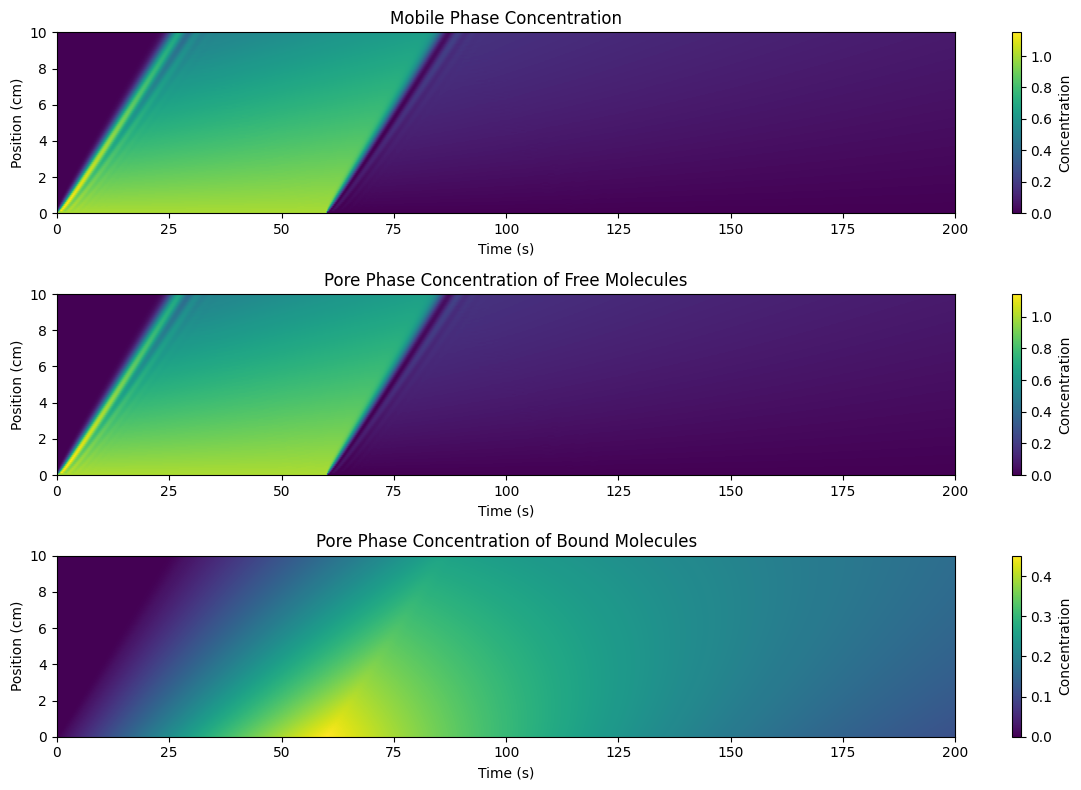

Final bound concentration: 14.213232351184747


In [20]:
## modèle basé sur les équations de transfert de masse et sur 'the open particle surface area per liquid volume' and 'The open pore surface area per pore volume' (taille de la molécule implicite)
## -> plus proche du papier
## There is still a fitting parameter :  self.affinity

## pH,sel
class Chromatography(Filtration):

    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, feed, filter_size, particle_size, temperature, solvent_viscosity, affinity, epsilon_c, epsilon_p):

        super().__init__(feed = None, filter_size = None, type_filtration = 'chromatography', filter_charge = None, flow_rate = v, pressure = None,temperature = temperature)

        """
        Initialise une instance de la classe Chromatography, qui hérite de la classe Filtration.
        :param L: longueur de la colonne (cm).
        :param T: temps de la chromatographie.
        :param v: vitesse linéaire de la phase mobile (m/s).
        :param  D: coefficient de diffusion (m^2/s).
        :param Nx: disrcétisation spatiale.
        :param Nt: discrétisation temporelle.
        :param pulse_duration: durée d'alimentation.
        :param pulse_concentration: concentration de l'alimentation.
        :param  feed: mélange à filtrer.
        :param particle_size: taille des particules.
        :param temperature: température (Kelvin).
        :param solvent_viscosity: viscosité du solvant.
        :param affinity: constante d'affinité.
        :param epsilon_c: porosité de la colonne.
        :param e psilon_p: porosité des particules.
        """


        self.L = L  # longueur de la colonne (cm)
        self.T = T  # temps de la chromatographie
        self.v = v  # velocité linéaire de la phase mobile (m/s)
        self.D = D  # coefficient de diffusion  (m^2/s)
        self.Nx = Nx  # discrétisation spatiale
        self.Nt = Nt  # discrétisation temporelle
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration  # durée d'alimentation
        self.pulse_concentration = pulse_concentration  # concentration de l'alimentation
        self.particle_size = particle_size  # taille des particules
        self.temperature = temperature  # température (Kelvin)
        self.solvent_viscosity = solvent_viscosity  # viscosité du solvant
        self.affinity = affinity  # constante d'affinité
        self.epsilon_c = epsilon_c  # porosité de la colonne
        self.epsilon_p = epsilon_p  # porosité des particules

        self.z = np.linspace(0, L, Nx)
        self.c = np.zeros(Nx)
        self.cp = np.zeros(Nx)
        self.q = np.zeros(Nx)

        self.c0 = lambda z: np.zeros_like(z)
        self.cp0 = lambda z: np.zeros_like(z)
        self.q0 = lambda z: np.zeros_like(z)

        self.apply_initial_conditions()

        self.c_history = [self.c.copy()]
        self.cp_history = [self.cp.copy()]
        self.q_history = [self.q.copy()]

    def apply_initial_conditions(self):
        self.c = self.c0(self.z)
        self.cp = self.cp0(self.z)
        self.q = self.q0(self.z)

    def calculate_diffusion_coefficient(self):
        """
        Calcule le coefficient de diffusion de Fick effectif en fonction de la température et de la viscosité du solvant.
        :return: coefficient de diffusion ajusté.
        """
        return self.D * (self.temperature / 298.15) /self.solvent_viscosity

    def calculate_open_surface_area(self):
        """
        Calcule la surface ouverte par volume de liquide pour les particules.
        """
        return 6 / self.particle_size

    def calculate_R(self, c, cp, q):
        """
        Calcule le taux de transport R pour la phase mobile.
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre.
        :param q: concentration dans les pores de la phase liée.
        :return: terme de réaction R.
        """
        phi_l = (1 - self.epsilon_c) * self.calculate_open_surface_area() * self.epsilon_p / self.epsilon_c
        rp = self.calculate_rp(c, cp)
        return -phi_l * rp

    def calculate_Rp(self, c, cp, q):
        """
        Calcule le taux de transport des free molecules Rp pour la phase libre dans les pores.
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre.
        :param q: concentration dans les pores de la phase liée.
        :return: terme de réaction Rp.
        """

        phi_p = self.calculate_open_surface_area()
        rp = self.calculate_rp(c, cp)
        rq = self.calculate_rq(cp, q)
        return phi_p * rp + rq

    def calculate_Rq(self, c, cp, q):
        """
        Calcule le taux de transport des molécules liées Rq pour la phase liée dans les pores.
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre.
        :param q: concentration dans les pores de la phase liée.
        :return: terme de réaction Rq.
        """

        rq = self.calculate_rq(cp, q)
        return rq

    def calculate_rp(self, c, cp):
        """
        Calcule le terme de réaction rp pour la phase mobile.
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre.
        :return: terme de réaction rp.
        """

        return self.affinity * (c - cp)

    def calculate_rq(self, cp, q):
        """
        Calcule le terme de réaction rq pour la phase liée dans les pores.
        :param cp: concentration dans les pores de la phase libre.
        :param q: concentration dans les pores de la phase liée.
        :return: terme de réaction rq.
        """

        return self.affinity * (cp - q)

    def perform_chromatography(self):
        """
        Effectue la simulation de la chromatographie en résolvant les équations de transfert de masse.
        """
        for n in range(self.Nt):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c, self.dx)
            N = self.v * self.c + J

            dc_dt = -np.gradient(N, self.dx) - self.calculate_R(self.c, self.cp, self.q)
            dcp_dt = self.calculate_Rp(self.c, self.cp, self.q)
            dq_dt = self.calculate_Rq(self.c, self.cp, self.q)

            # Ensure no overflow or invalid values
            self.c = np.clip(self.c + dc_dt * self.dt, 0, np.inf)
            self.cp = np.clip(self.cp + dcp_dt * self.dt, 0, np.inf)
            self.q = np.clip(self.q + dq_dt * self.dt, 0, np.inf)

            if t <= self.pulse_duration:
                self.c[0] = self.pulse_concentration
            else:
                self.c[0] = 0.0

            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())
            self.q_history.append(self.q.copy())


    def plot_result(self):
        c_history = np.array(self.c_history)
        cp_history = np.array(self.cp_history)
        q_history = np.array(self.q_history)

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.title('Mobile Phase Concentration')
        plt.imshow(c_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 2)
        plt.title('Pore Phase Concentration of Free Molecules')
        plt.imshow(cp_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 3)
        plt.title('Pore Phase Concentration of Bound Molecules')
        plt.imshow(q_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.tight_layout()
        plt.show()

    def get_final_bound_concentration(self):
        """
        Retourne la concentration totale des molécules cibles qui sont restées accrochées dans la colonne.
        """
        return np.sum(self.q)

    def calculate_mass_recovered(self):
        """
        Calcule la masse totale des molécules cibles récupérées dans la colonne.
        """
        mass_recovered = np.trapz(self.q, dx=self.dx)
        return mass_recovered


    def get_yield(self):
        """
        Calcule le rendement du processus de chromatographie en comparant la masse récupérée à la masse injectée. Cf papier
        """
        mass_recovered = self.calculate_mass_recovered()
        mass_injected = self.pulse_concentration * self.pulse_duration * self.v
        return mass_recovered / mass_injected


feed = [{'type': 'A', 'concentration': 1.0}, {'type': 'B', 'concentration': 0.5}]
filter_size = 1.0

particle_size = 0.005
L = 10
T = 200.0
v = 0.1
D = 0.01
Nx = 100
Nt = 10000
pulse_duration = 60
pulse_concentration = 1
temperature = 293.15
solvent_viscosity = 1
affinity = 0.01
epsilon_c = 0.4
epsilon_p = 0.5

chromato = Chromatography(
    L=L,
    T=T,
    v=v,
    D=D,
    Nx=Nx,
    Nt=Nt,
    pulse_duration=pulse_duration,
    pulse_concentration=pulse_concentration,
    feed=feed,
    filter_size=filter_size,
    particle_size=particle_size,
    temperature=temperature,
    solvent_viscosity=solvent_viscosity,
    affinity=affinity,
    epsilon_c=epsilon_c,
    epsilon_p=epsilon_p
)

chromato.perform_chromatography()
chromato.plot_result()
final_bound_concentration = chromato.get_final_bound_concentration()
print("Final bound concentration:", final_bound_concentration)

In [ ]:
m,y =chromato.calculate_mass_recovered(), chromato.get_yield()
print(m,y)

1.4076773574385342 0.23461289290642237


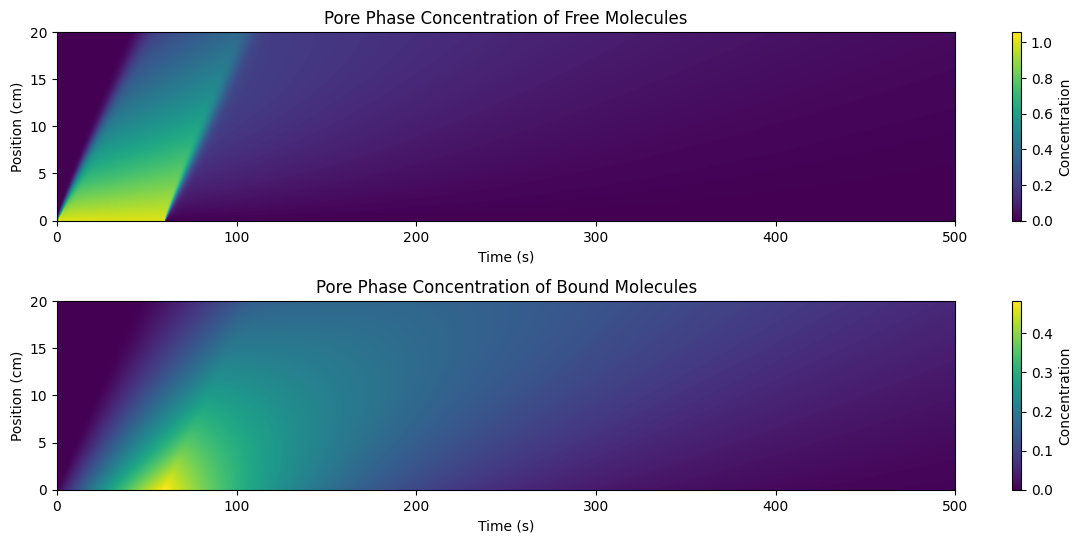

Final bound concentration: 2.6421367752999982


In [38]:
## Test avec Ph, ligand, conductivité
class Chromatography(Filtration):

    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, feed, filter_size, particle_size, temperature, solvent_viscosity, affinity, epsilon_c, epsilon_p, pH, conductivity, ligand_density):
        super().__init__(feed=None, filter_size=None, type_filtration='chromatography', filter_charge=None, flow_rate=v, pressure=None, temperature=temperature)

        self.L = L  # longueur de la colonne (cm)
        self.T = T  # temps de la chromatographie
        self.v = v  # vitesse linéaire de la phase mobile (m/s)
        self.D = D  # coefficient de diffusion (m^2/s)
        self.Nx = Nx  # discrétisation spatiale
        self.Nt = Nt  # discrétisation temporelle
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration  # durée d'alimentation
        self.pulse_concentration = pulse_concentration  # concentration de l'alimentation
        self.particle_size = particle_size  # taille des particules
        self.temperature = temperature  # température (Kelvin)
        self.solvent_viscosity = solvent_viscosity  # viscosité du solvant
        self.affinity = affinity  # constante d'affinité
        self.epsilon_c = epsilon_c  # porosité de la colonne
        self.epsilon_p = epsilon_p  # porosité des particules
        self.pH = pH  # pH du solvant
        self.conductivity = conductivity  # conductivité du solvant
        self.ligand_density = ligand_density  # densité de ligand

        self.z = np.linspace(0, L, Nx)
        self.c = np.zeros(Nx)
        self.cp = np.zeros(Nx)
        self.q = np.zeros(Nx)

        self.c0 = lambda z: np.zeros_like(z)
        self.cp0 = lambda z: np.zeros_like(z)
        self.q0 = lambda z: np.zeros_like(z)

        self.apply_initial_conditions()

        self.c_history = [self.c.copy()]
        self.cp_history = [self.cp.copy()]
        self.q_history = [self.q.copy()]

    def apply_initial_conditions(self):
        self.c = self.c0(self.z)
        self.cp = self.cp0(self.z)
        self.q = self.q0(self.z)

    def calculate_diffusion_coefficient(self):
        """
        Calcule le coefficient de diffusion de Fick effectif en fonction de la température et de la viscosité du solvant.
        :return: coefficient de diffusion ajusté.
        """
        return self.D * (self.temperature / 298.15) / self.solvent_viscosity

    def calculate_open_surface_area_per_volume(self):
        """
        Calcule la surface ouverte par volume de liquide pour les particules.
        """
        return 6 / self.particle_size

    def calculate_open_pore_surface_area_per_volume(self):
        """
        Calcule la surface ouverte des pores par volume de pores.
        """
        return 6 / self.particle_size

    def calculate_affinity_factor(self):
        """
        Calcule le facteur d'affinité ajusté en fonction du pH, de la conductivité et de la densité de ligand.
        :return: facteur d'affinité ajusté.
        """
        if self.pH != 7.5:
            a = self.affinity * (exp(-abs(7.5 - self.pH)))  # Pas d'interaction si le pH n'est pas 7.5
        else:
            a = self.affinity

        return  a * (1 + self.ligand_density * exp(-abs(7-self.pH)) ) * (1 / (1 + self.conductivity))
        #l'affinité est maximale à un pH proche de 7 et diminue rapidement (exp) lorsque le pH s'éloigne de cette valeur.

    def calculate_R(self, c, cp, q):
        """
        Calcule le taux de transport R pour la phase mobile.
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre.
        :param q: concentration dans les pores de la phase liée.
        :return: terme de réaction R.
        """
        phi_l = (1 - self.epsilon_c) * self.calculate_open_surface_area_per_volume() * self.epsilon_p / self.epsilon_c
        rp = self.calculate_rp(c, cp)
        return -phi_l * rp

    def calculate_Rp(self, c, cp, q):
        """
        Calcule le taux de transport des free molecules Rp pour la phase libre dans les pores.
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre.
        :param q: concentration dans les pores de la phase liée.
        :return: terme de réaction Rp.
        """
        phi_p = self.calculate_open_pore_surface_area_per_volume()
        rp = self.calculate_rp(c, cp)
        rq = self.calculate_rq(cp, q)
        return phi_p * rp + rq

    def calculate_Rq(self, c, cp, q):
        """
        Calcule le taux de transport des molécules liées Rq pour la phase liée dans les pores.
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre.
        :param q: concentration dans les pores de la phase liée.
        :return: terme de réaction Rq.
        """
        rq = self.calculate_rq(cp, q)
        return rq

    def calculate_rp(self, c, cp):
        """
        Calcule le terme de réaction rp pour la phase mobile.
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre.
        :return: terme de réaction rp.
        """
        affinity_factor = self.calculate_affinity_factor()
        return affinity_factor * (c - cp)

    def calculate_rq(self, cp, q):
        """
        Calcule le terme de réaction rq pour la phase liée dans les pores.
        :param cp: concentration dans les pores de la phase libre.
        :param q: concentration dans les pores de la phase liée.
        :return: terme de réaction rq.
        """
        affinity_factor = self.calculate_affinity_factor()
        return affinity_factor * (cp - q)

    def perform_chromatography(self):
        """
        Effectue la simulation de la chromatographie en résolvant les équations de transfert de masse.
        """
        for n in range(self.Nt):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c, self.dx)
            N = self.v * self.c + J

            dc_dt = -np.gradient(N, self.dx) - self.calculate_R(self.c, self.cp, self.q)
            dcp_dt = self.calculate_Rp(self.c, self.cp, self.q)
            dq_dt = self.calculate_Rq(self.c, self.cp, self.q)

            # Ensure no overflow or invalid values
            self.c = np.clip(self.c + dc_dt * self.dt, 0, np.inf)
            self.cp = np.clip(self.cp + dcp_dt * self.dt, 0, np.inf)
            self.q = np.clip(self.q + dq_dt * self.dt, 0, np.inf)

            if t <= self.pulse_duration:
                self.c[0] = self.pulse_concentration
            else:
                self.c[0] = 0.0

            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())
            self.q_history.append(self.q.copy())

    def plot_result(self):
        c_history = np.array(self.c_history)
        cp_history = np.array(self.cp_history)
        q_history = np.array(self.q_history)

        plt.figure(figsize=(12, 8))



        plt.subplot(3, 1, 2)
        plt.title('Pore Phase Concentration of Free Molecules')
        plt.imshow(cp_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 3)
        plt.title('Pore Phase Concentration of Bound Molecules')
        plt.imshow(q_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.tight_layout()
        plt.show()

    def get_final_bound_concentration(self):
        """
        Retourne la concentration totale des molécules cibles qui sont restées accrochées dans la colonne.
        """
        return np.sum(self.q)

    def calculate_mass_recovered(self):
        """
        Calcule la masse totale des molécules cibles récupérées dans la colonne.
        """
        mass_recovered = np.trapz(self.q, dx=self.dx)
        return mass_recovered


    def get_yield(self):
        """
        Calcule le rendement du processus de chromatographie en comparant la masse récupérée à la masse injectée. Cf papier
        """
        mass_recovered = self.calculate_mass_recovered()
        mass_injected = self.pulse_concentration * self.pulse_duration * self.v
        return mass_recovered / mass_injected


feed = [{'type': 'A', 'concentration': 1.0}, {'type': 'B', 'concentration': 0.5}]
filter_size = 1.0

particle_size = 0.005
L = 20
T = 500.0
v = 0.1
D = 0.01
Nx = 100
Nt = 10000
pulse_duration = 60
pulse_concentration = 1
temperature = 293.15
solvent_viscosity = 0.5
affinity = 0.01
epsilon_c = 0.4
epsilon_p = 0.5
pH = 7.5
conductivity = 0.3
ligand_density = 0.7

chromato = Chromatography(
    L=L,
    T=T,
    v=v,
    D=D,
    Nx=Nx,
    Nt=Nt,
    pulse_duration=pulse_duration,
    pulse_concentration=pulse_concentration,
    feed=feed,
    filter_size=filter_size,
    particle_size=particle_size,
    temperature=temperature,
    solvent_viscosity=solvent_viscosity,
    affinity=affinity,
    epsilon_c=epsilon_c,
    epsilon_p=epsilon_p,
    pH = pH,
    conductivity = conductivity,
    ligand_density = ligand_density,
)

chromato.perform_chromatography()
chromato.plot_result()
final_bound_concentration = chromato.get_final_bound_concentration()
print("Final bound concentration:", final_bound_concentration)

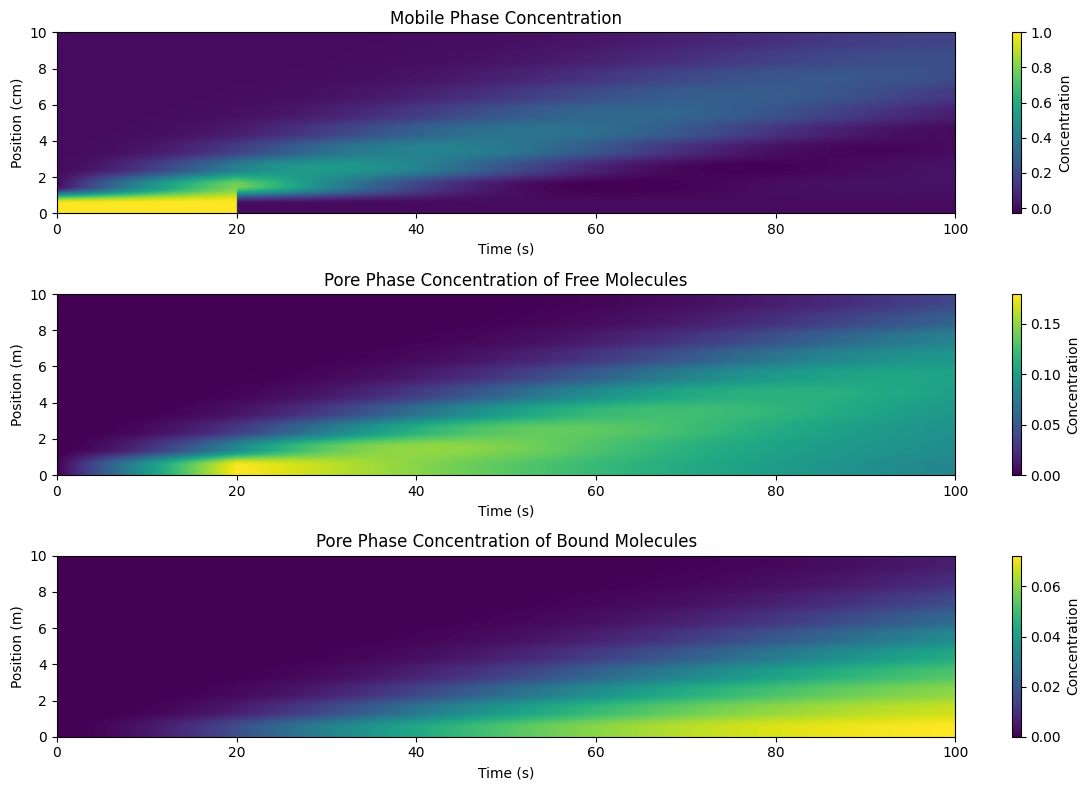

In [ ]:
## Filtration baséée sur la taille de la molécule

class Filtration:
    def __init__(self, feed, filter_size):
        self.feed = feed
        self.filter_size = filter_size

class Chromatography(Filtration):
    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, target_molecule, feed, filter_size, particle_size, molecule_size, temperature, solvent_viscosity, affinity):
        super().__init__(feed, filter_size)

        self.L = L # longueur de la colonne (cm)
        self.T = T # temps de la chromatographie
        self.v = v # velocité linéaire de la phase mobile (m/s)
        self.D = D # coefficient de diffusion  (m^2/s)
        self.Nx = Nx # discrétisation spatiale
        self.Nt = Nt  # discrétisation temporelle
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration # durée d'alimentation
        self.pulse_concentration = pulse_concentration # concentration de l'alimentation
        self.target_molecule = target_molecule # molécule d'interêt
        self.particle_size = particle_size
        self.molecule_size = molecule_size
        self.temperature = temperature
        self.solvent_viscosity = solvent_viscosity
        self.affinity = affinity

        self.z = np.linspace(0, L, Nx)

        self.c = np.zeros(Nx)
        self.cp = np.zeros(Nx)
        self.q = np.zeros(Nx)

        self.c0 = lambda z: np.zeros_like(z)
        self.cp0 = lambda z: np.zeros_like(z)
        self.q0 = lambda z: np.zeros_like(z)

        self.apply_initial_conditions()

        # Transport and production rates
        self.R = self.calculate_R
        self.Rp = self.calculate_Rp
        self.Rq = self.calculate_Rq

        self.c_history = [self.c.copy()]
        self.cp_history = [self.cp.copy()]
        self.q_history = [self.q.copy()]

    def apply_initial_conditions(self):
        self.c = self.c0(self.z)
        self.cp = self.cp0(self.z)
        self.q = self.q0(self.z)

    def calculate_diffusion_coefficient(self):
        return self.D * (self.temperature / 298.15) * (1.0 / self.solvent_viscosity)

    def calculate_R(self, c, cp, q):
        return self.affinity * (c - cp) * (self.particle_size / (self.particle_size + self.molecule_size))

    def calculate_Rp(self, c, cp, q):
        return self.affinity * (c - cp) * (self.particle_size / (self.particle_size + self.molecule_size))

    def calculate_Rq(self, c, cp, q):
        return self.affinity * (cp - q) * (self.particle_size / (self.particle_size + self.molecule_size))

    def perform_chromatography(self):
        for n in range(self.Nt):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c, self.dx)
            N = self.v * self.c + J

            dc_dt = -np.gradient(N, self.dx) - self.R(self.c, self.cp, self.q)
            dcp_dt = self.Rp(self.c, self.cp, self.q)
            dq_dt = self.Rq(self.c, self.cp, self.q)

            self.c += dc_dt * self.dt
            self.cp += dcp_dt * self.dt
            self.q += dq_dt * self.dt

            if t <= self.pulse_duration:
                self.c[0] = self.pulse_concentration
            else:
                self.c[0] = 0.0


            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())
            self.q_history.append(self.q.copy())

    def plot_result(self):
        c_history = np.array(self.c_history)
        cp_history = np.array(self.cp_history)
        q_history = np.array(self.q_history)

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.title('Mobile Phase Concentration')
        plt.imshow(c_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 2)
        plt.title('Pore Phase Concentration of Free Molecules')
        plt.imshow(cp_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.subplot(3, 1, 3)
        plt.title('Pore Phase Concentration of Bound Molecules')
        plt.imshow(q_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.tight_layout()
        plt.show()

    def plot_results(self,nbr_simu):
        time_points = np.linspace(0, self.T, len(self.c_history))

        size  = self.molecule_size * i * 10
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.title(f'Mobile Phase Concentration for molecule size {size}')
        plt.imshow(np.array(self.c_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.subplot(2, 1, 2)
        plt.title(f'Pore Phase Concentration of Free molecule size {self.charges[i]}')
        plt.imshow(np.array(self.cp_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.tight_layout()
        plt.show()


# Parameters
L = 10
T = 100.0
v = 0.1
D = 0.01
Nx = 10
Nt = 10000
pulse_duration = 20
pulse_concentration = 1
target_molecule = 'A'
feed = [{'type': 'A', 'concentration': 1.0}, {'type': 'B', 'concentration': 0.5}]
filter_size = 1.0
particle_size = .01  # Example particle size
molecule_size = 0.0001  # Example molecule size
temperature = 298.15  # Example temperature in Kelvin (25°C)
solvent_viscosity = 1  # Example solvent viscosity (arbitrary units)
affinity = 0.01  # Example affinity constant
size = [.0001,.001,.01]

# Instantiate and run chromatography
chromatography = Chromatography(L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, target_molecule, feed, filter_size, particle_size, molecule_size, temperature, solvent_viscosity, affinity)
chromatography.perform_chromatography()
chromatography.plot_result()

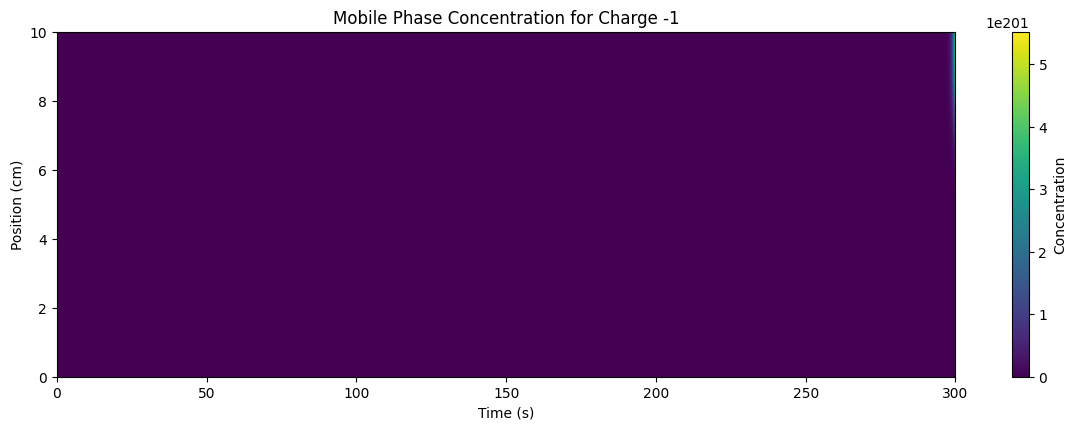

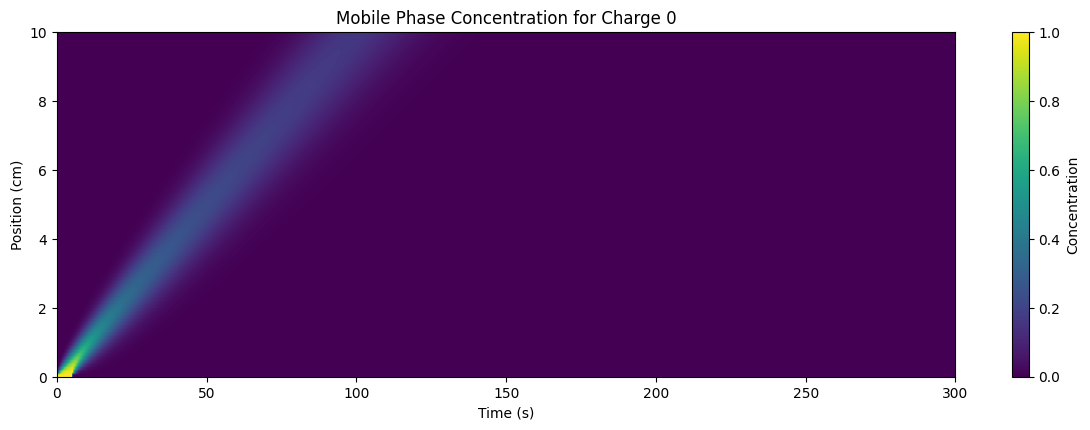

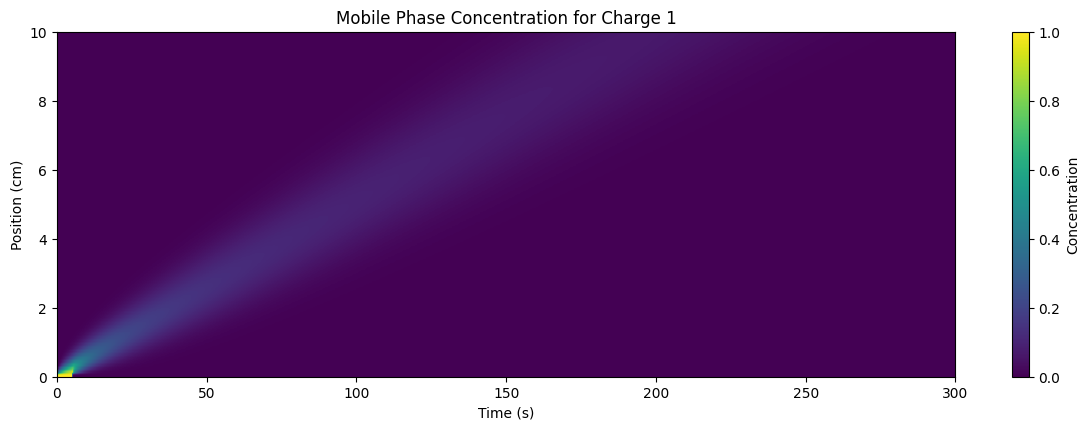

In [ ]:
## Filtration baséée sur la charge de la molécule

import numpy as np
import matplotlib.pyplot as plt

class ChromatographySimulation:
    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, charges, retention_factors, temperature,solvent_viscosity):
        self.L = L  # Length of the column
        self.T = T  # Total time
        self.v = v  # Linear mobile phase velocity
        self.D = D  # Diffusion coefficient
        self.Nx = Nx  # Number of spatial grid points
        self.Nt = Nt  # Number of time steps
        self.dx = L / Nx  # Spatial step size
        self.dt = T / Nt  # Time step size
        self.pulse_duration = pulse_duration
        self.pulse_concentration = pulse_concentration
        self.charges = charges  # List of charges of the molecules
        self.retention_factors = retention_factors  # Retention factors for the molecules
        self.temperature = temperature
        self.solvent_viscosity = solvent_viscosity

        self.c = np.zeros((len(charges), Nx))  # Mobile phase concentration for each molecule
        self.cp = np.zeros((len(charges), Nx))  # Pore phase concentration of free molecules for each molecule

        self.z = np.linspace(0, L, Nx)
        self.c_history = []
        self.cp_history = []
    def calculate_diffusion_coefficient(self):
        return self.D * (self.temperature / 298.15) * (1.0 / self.solvent_viscosity)

    def R(self, c, cp, charge, retention_factor):
        return  (c - cp) * charge

    def simulate(self):
        for n in range(self.Nt):
            t = n * self.dt
            for i in range(len(self.charges)):
                charge = self.charges[i]
                retention_factor = self.retention_factors[i]

                J = -self.D * np.gradient(self.c[i], self.dx)
                N = self.v * self.c[i] + J

                dc_dt = -np.gradient(N, self.dx) - self.R(self.c[i], self.cp[i], charge, retention_factor)
                dcp_dt = self.R(self.c[i], self.cp[i], charge, retention_factor)

                self.c[i] += dc_dt * self.dt
                self.cp[i] += dcp_dt * self.dt

                if t <= self.pulse_duration:
                    self.c[i][0] = self.pulse_concentration

                else:
                    self.c[i][0] = 0.0


            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())

    def plot_results(self):

        for i in range(len(self.charges)):
            plt.figure(figsize=(12, 8))
            plt.subplot(2, 1, 1)
            plt.title(f'Mobile Phase Concentration for Charge {self.charges[i]}')
            plt.imshow(np.array(self.c_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
            plt.colorbar(label='Concentration')
            plt.xlabel('Time (s)')
            plt.ylabel('Position (cm)')

            plt.tight_layout()
            plt.show()

# Parameters
L = 10.0
T = 300.0
v = 0.1
D = 0.01
Nx = 100
Nt = 1000
pulse_duration = 5
pulse_concentration = 1
charges = [-1, 0, 1]  # Example charges for different molecules
retention_factors = [0.1, 0.1, 0.1]  # Example retention factors
solvent_viscosity = 0.9
temperature = 298.15

# Create simulation instance
simulation = ChromatographySimulation(L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, charges, retention_factors, temperature, solvent_viscosity)
simulation.simulate()
simulation.plot_results()

## TEST

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class Filtration:
    def __init__(self, feed, filter_size):
        self.feed = feed
        self.filter_size = filter_size

class Chromatography(Filtration):
    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, target_molecule, feed, filter_size, particle_size, molecule_size, temperature, solvent_viscosity, affinity, epsilon_c, epsilon_p):
        super().__init__(feed, filter_size)
        self.L = L  # longueur de la colonne (cm)
        self.T = T  # temps de la chromatographie
        self.v = v  # velocité linéaire de la phase mobile (m/s)
        self.D = D  # coefficient de diffusion  (m^2/s)
        self.Nx = Nx  # discrétisation spatiale
        self.Nt = Nt  # discrétisation temporelle
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration  # durée d'alimentation
        self.pulse_concentration = pulse_concentration  # concentration de l'alimentation
        self.target_molecule = target_molecule  # molécule d'intérêt
        self.particle_size = particle_size  # taille des particules
        self.molecule_size = molecule_size  # taille des molécules
        self.temperature = temperature  # température (Kelvin)
        self.solvent_viscosity = solvent_viscosity  # viscosité du solvant
        self.affinity = affinity  # constante d'affinité
        self.epsilon_c = epsilon_c  # porosité de la colonne
        self.epsilon_p = epsilon_p  # porosité des particules

        self.z = np.linspace(0, L, Nx)
        self.c = np.zeros(Nx)
        self.cp = np.zeros(Nx)
        self.q = np.zeros(Nx)

        self.c0 = lambda z: np.zeros_like(z)
        self.cp0 = lambda z: np.zeros_like(z)
        self.q0 = lambda z: np.zeros_like(z)

        self.apply_initial_conditions()

        self.c_history = [self.c.copy()]
        self.cp_history = [self.cp.copy()]
        self.q_history = [self.q.copy()]

    def apply_initial_conditions(self):
        self.c = self.c0(self.z)
        self.cp = self.cp0(self.z)
        self.q = self.q0(self.z)

    def calculate_diffusion_coefficient(self):
        return self.D * (self.temperature / 298.15) * (1.0 / self.solvent_viscosity)

    def calculate_open_surface_area(self):
        return 6 / self.particle_size

    def calculate_R(self, c, cp, q):
        phi_l = (1 - self.epsilon_c) * self.calculate_open_surface_area() * self.epsilon_p / self.epsilon_c
        rp = self.calculate_rp(c, cp)
        return -phi_l * rp

    def calculate_Rp(self, c, cp, q):
        phi_p = self.calculate_open_surface_area()
        rp = self.calculate_rp(c, cp)
        rq = self.calculate_rq(cp, q)
        return phi_p * rp + rq

    def calculate_Rq(self, c, cp, q):
        rq = self.calculate_rq(cp, q)
        return rq

    def calculate_rp(self, c, cp):
        return self.affinity * (c - cp)

    def calculate_rq(self, cp, q):
        return self.affinity * (cp - q)

    def perform_chromatography(self):
        for n in range(self.Nt):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c, self.dx)
            N = self.v * self.c + J

            dc_dt = -np.gradient(N, self.dx) - self.calculate_R(self.c, self.cp, self.q)
            dcp_dt = self.calculate_Rp(self.c, self.cp, self.q)
            dq_dt = self.calculate_Rq(self.c, self.cp, self.q)

            # Ensure no overflow or invalid values
            self.c = (self.c + dc_dt * self.dt, 0, np.inf)
            self.cp = (self.cp + dcp_dt * self.dt, 0, np.inf)
            self.q = (self.q + dq_dt * self.dt, 0, np.inf)

            if t <= self.pulse_duration:
                self.c[0] = self.pulse_concentration
            else:
                self.c[0] = 0.0

            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())
            self.q_history.append(self.q.copy())

    def plot_result(self):
        c_history = np.array(self.c_history)
        cp_history = np.array(self.cp_history)
        q_history = np.array(self.q_history)

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.title('Mobile Phase Concentration')
        plt.imshow(c_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 2)
        plt.title('Pore Phase Concentration of Free Molecules')
        plt.imshow(cp_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 3)
        plt.title('Pore Phase Concentration of Bound Molecules')
        plt.imshow(q_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.tight_layout()
        plt.show()

    def get_final_bound_concentration(self):
        return self.q[-1]

# Initialize the Chromatography with the given parameters
particle_size = 0.005
molecule_size = 5e-05
L = 10
T = 200.0
v = 0.1
D = 0.01
Nx = 100
Nt = 10000
pulse_duration = 20
pulse_concentration = 1
target_molecule = 'A'
feed = [{'type': 'A', 'concentration': 1.0}, {'type': 'B', 'concentration': 0.5}]
filter_size = 1.0
temperature = 293.15  # Example temperature in Kelvin (25°C)
solvent_viscosity = 0.1  # Example solvent viscosity (arbitrary units)
affinity = 0.01  # Example affinity constant
epsilon_c = 0.4  # Porosity of the column
epsilon_p = 0.5  # Porosity of the particles

chromato = Chromatography(
    L=L,
    T=T,
    v=v,
    D=D,
    Nx=Nx,
    Nt=Nt,
    pulse_duration=pulse_duration,
    pulse_concentration=pulse_concentration,
    target_molecule=target_molecule,
    feed=feed,
    filter_size=filter_size,
    particle_size=particle_size,
    molecule_size=molecule_size,
    temperature=temperature,
    solvent_viscosity=solvent_viscosity,
    affinity=affinity,
    epsilon_c=epsilon_c,
    epsilon_p=epsilon_p
)
chromato.perform_chromatography()
chromato.plot_result()
final_bound_concentration = chromato.get_final_bound_concentration()
print("Final bound concentration:", final_bound_concentration)


TypeError: 'tuple' object does not support item assignment

In [ ]:
particle_size = 0.005
molecule_size = 5e-05
temperature = 293.15
solvent_viscosity =  1.2
affinity =  0.01
epsilon_c =  0.3
epsilon_p  = 0.5
L = 10
T = 2000.0
v = 0.1
D = 0.01
Nx = 100
Nt = 10000
pulse_duration = 20
pulse_concentration = 1
target_molecule = 'A'
feed = [{'type': 'A', 'concentration': 1.0}, {'type': 'B', 'concentration': 0.5}]
filter_size = 1.0

Best Parameters:
{'particle_size': 0.005, 'molecule_size': 5e-05, 'temperature': 293.15, 'solvent_viscosity': 1.2, 'affinity': 0.01, 'epsilon_c': 0.3, 'epsilon_p': 0.5} <br>
Best Bound Molecule Concentration:
2.7663912297019095e+83


In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Chargement des données de YEASTRACT
# (Pour cet exemple, supposons que les données sont stockées localement dans un fichier CSV)
data = pd.read_csv('yeastract_data.csv')

# Préparation des données pour l'entraînement du modèle
X = data[['Glucose', 'Ethanol', 'Oxygen']]
y_mu = data['GrowthRate']
y_qG = data['GlucoseConsumptionRate']
y_qO = data['OxygenConsumptionRate']

# Division des données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_mu_train, y_mu_test = train_test_split(X, y_mu, test_size=0.2, random_state=42)
X_train, X_test, y_qG_train, y_qG_test = train_test_split(X, y_qG, test_size=0.2, random_state=42)
X_train, X_test, y_qO_train, y_qO_test = train_test_split(X, y_qO, test_size=0.2, random_state=42)

# Entraînement des modèles de Random Forest
mu_model = RandomForestRegressor(n_estimators=100, random_state=42)
mu_model.fit(X_train, y_mu_train)

qG_model = RandomForestRegressor(n_estimators=100, random_state=42)
qG_model.fit(X_train, y_qG_train)

qO_model = RandomForestRegressor(n_estimators=100, random_state=42)
qO_model.fit(X_train, y_qO_train)

# Prédictions pour les données de test
y_mu_pred = mu_model.predict(X_test)
y_qG_pred = qG_model.predict(X_test)
y_qO_pred = qO_model.predict(X_test)

# Évaluation des modèles
from sklearn.metrics import mean_squared_error
print("MSE Growth Rate: ", mean_squared_error(y_mu_test, y_mu_pred))
print("MSE Glucose Consumption Rate: ", mean_squared_error(y_qG_test, y_qG_pred))
print("MSE Oxygen Consumption Rate: ", mean_squared_error(y_qO_test, y_qO_pred))

In [ ]:
class HybridYeastGrowthModel:
    def __init__(self, mu_model, qG_model, qO_model, Y_XG=0.5, Y_EG=0.1, G0=20, X0=0.4, E0=0, O0=100):
        self.mu_model = mu_model  # modèle data-driven pour le taux de croissance
        self.qG_model = qG_model  # modèle data-driven pour le taux de consommation de glucose
        self.qO_model = qO_model  # modèle data-driven pour le taux de consommation d'oxygène
        self.Y_XG = Y_XG  # rendement de la biomasse sur le glucose (g/g)
        self.Y_EG = Y_EG  # rendement de l'éthanol sur le glucose (g/g)
        # concentrations initiales
        self.G0 = G0  # concentration initiale de glucose (g/L)
        self.X0 = X0  # concentration initiale de biomasse (g/L)
        self.E0 = E0  # concentration initiale d'éthanol (g/L)
        self.O0 = O0  # concentration initiale d'oxygène (%)
        self.solution = None  # Variable pour stocker la solution

    def model(self, y, t):
        G, X, E, O = y
        inputs = np.array([[G, E, O]])
        mu = self.mu_model.predict(inputs)[0]
        qG = self.qG_model.predict(inputs)[0]
        qO = self.qO_model.predict(inputs)[0]

        dG_dt = -qG * X
        dX_dt = mu * X
        dE_dt = qG * X * self.Y_EG
        dO_dt = -qO * X
        return [dG_dt, dX_dt, dE_dt, dO_dt]

    def get_solution(self, t_end=30, n=100, plot=True):
        t = np.linspace(0, t_end, n)  # en heure
        y0 = [self.G0, self.X0, self.E0, self.O0]
        # Résoudre les équations différentielles avec odeint
        self.solution = odeint(self.model, y0, t)
        G, X, E, O = self.solution.T
        if plot:
            # Créer le graphique
            plt.figure(figsize=(10, 6))
            plt.plot(t, G, label='Glucose (g/L)')
            plt.plot(t, X, label='Biomasse (g/L)')
            plt.plot(t, E, label='Éthanol (g/L)')
            plt.plot(t, O, label='Oxygène (%)')
            plt.xlabel('Temps (h)')
            plt.ylabel('Concentration')
            plt.title('Modèle Hybride de Croissance de Levure')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            return G, X, E, O

    def get_masse_X(self, taille):  # taille en L
        if self.solution is None:
            self.get_solution(plot=False)
        G, X, E, O = self.solution.T
        return X[-1] * taille  # retour de la biomasse en g

# Exemple d'utilisation
hybrid_model = HybridYeastGrowthModel(mu_model, qG_model, qO_model)
hybrid_model.get_solution()


In [ ]:
L = 10
T = 300.0
v = 0.1
D = 0.01
Nx = 100
Nt = 10000
pulse_duration = 60
pulse_concentration = 1
feed = [{'type': 'A', 'concentration': 1.0}, {'type': 'B', 'concentration': 0.5}]
filter_size = 1.0

particle_sizes = [0.005, 0.01, 0.02]
molecule_sizes = [0.00005, 0.0001, 0.0002]
temperatures = [298.15]
solvent_viscosities = [0.8, 1, 1.2]
affinities = [0.005, 0.01, 0.02]
epsilon_cs = [0.3, 0.4, 0.5]
epsilon_ps = [0.3, 0.4, 0.5]
pH_values = [7.5]
conductivities = [0.0, 0.5]  # Including different conductivities
ligand_densities = [0.1, 0.5, 1.0]  # Including different ligand densities
best_bound_concentration = 0
best_parameters = {}

for particle_size in particle_sizes:
    for molecule_size in molecule_sizes:
        for temperature in temperatures:
            for solvent_viscosity in solvent_viscosities:
                for affinity in affinities:
                    for epsilon_c in epsilon_cs:
                        for epsilon_p in epsilon_ps:
                            for pH in pH_values:
                                for conductivity in conductivities:
                                    for ligand_density in ligand_densities:
                                        # Instantiate and run chromatography
                                        chromatography = Chromatography(
                                            feed=feed,
                                            filter_size=filter_size,
                                            L = L,
                                            T = T,
                                            v = v,
                                            D = D,
                                            Nx = Nx,
                                            Nt = Nt,
                                            pulse_duration = pulse_duration,
                                            pulse_concentration = pulse_concentration,
                                            particle_size = particle_size,
                                            temperature = temperature,
                                            solvent_viscosity = solvent_viscosity,
                                            affinity = affinity,
                                            epsilon_c = epsilon_c,
                                            epsilon_p = epsilon_p,
                                            pH = pH,
                                            conductivity = conductivity,
                                            ligand_density = ligand_density
                                        )
                                        chromatography.perform_chromatography()
                                        final_bound_concentration = chromatography.get_final_bound_concentration()

                                        if final_bound_concentration > best_bound_concentration:
                                            best_bound_concentration = final_bound_concentration
                                            best_parameters = {
                                                'particle_size': particle_size,
                                                'molecule_size': molecule_size,
                                                'temperature': temperature,
                                                'solvent_viscosity': solvent_viscosity,
                                                'affinity': affinity,
                                                'epsilon_c': epsilon_c,
                                                'epsilon_p': epsilon_p,
                                                'pH': pH,
                                                'conductivity': conductivity,
                                                'ligand_density': ligand_density
                                            }

print("Best Parameters:")
print(best_parameters)
print("Best Bound Molecule Concentration:")
print(best_bound_concentration)


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1238: RuntimeWarning: overflow encountered in divide
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
<ipython-input-51-d10a70c4b95a>:87: RuntimeWarning: overflow encountered in multiply
  return -phi_l * rp
<ipython-input-51-d10a70c4b95a>:143: RuntimeWarning: invalid value encountered in subtract
  dc_dt = -np.gradient(N, self.dx) - self.calculate_R(self.c, self.cp, self.q)
<ipython-input-51-d10a70c4b95a>:100: RuntimeWarning: overflow encountered in multiply
  return phi_p * rp + rq
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1238: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1266: RuntimeWarning: invalid value encountered in scalar subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n
<ipython-inp

Best Parameters:
{'particle_size': 0.005, 'molecule_size': 5e-05, 'temperature': 298.15, 'solvent_viscosity': 1.2, 'affinity': 0.01, 'epsilon_c': 0.3, 'epsilon_p': 0.5, 'pH': 7.5, 'conductivity': 0.5, 'ligand_density': 1.0}
Best Bound Molecule Concentration:
1.410834601158192e+294
